In [4]:
!pip install -q biopython
!pip install Bio
!pip install -q ReportLab
#gseapy
!pip install -q gseapy

In [41]:
import gseapy as gp
from gseapy import dotplot
import pickle
import pandas as pd
import numpy as np

XGBoost and Random Forest return a list with the most important features to predict the condition of the cell. A common double-check done in bioinformatics is to check if this set of genes is involved in some biological path, or if these genes are just together "by chance".

To check this, you usually test your group against a dataset of set of genes well known for their function in some biological path. Checking how much our genes are over (or under) represented with respect to a set of genes in a specific biological path, we can compute an adjusted p-value, that will give us an idea of how sure we are that our set is linked to that pathway. 

To do so, we define:
* Our genes list, that is basically our set of significant genes for predicting the condition of Hypoxia or Normoxia. As we said before, this is the list of relevant genes returned by XGBoost and RF.
* A list of sets of genes, well known for being involved in biological paths. We choose as dataset for these sets the MSigDB_Hallmark_2020, since it's well recognized in literature, and it was shown in class.

The adjusted p-values will be computed over these two lists, using a default test given by the function gp.enrich, that is hypergeometric test, which calculates the probability of observing a given number of genes from the input list within a particular gene set, given the total number of genes in the dataset and the number of genes in the gene set.

In [14]:
df_dropseq_pathHFiltNorm = '../ai_lab/DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt'
df_dropseq_HFiltNorm = pd.read_csv(df_dropseq_pathHFiltNorm, delimiter=' ')

In [22]:
df_dropseq_HFiltNorm = df_dropseq_HFiltNorm.T
gene_names = df_dropseq_HFiltNorm.columns
print(gene_names)

Index(['H1-5', 'MALAT1', 'MT-RNR2', 'ARVCF', 'BCYRN1', 'ATXN7L2', 'IGFBP3',
       'H1-3', 'CTIF', 'RNF123',
       ...
       'BATF3', 'CDKN3', 'DLD', 'PMPCA', 'ZNF165', 'SCCPDH', 'NTAN1', 'CLIP2',
       'DUSP23', 'ZNF682'],
      dtype='object', length=3000)


In [32]:
# load the xgboost dropseq model and return the list of the 50 most important genes
filename = '/Users/filipporonzino/Downloads/dropseq_merged dataset'
with open(filename, 'rb') as f:
    xgboost_dropseq = pickle.load(f)['model']
feature_importance = xgboost_dropseq.feature_importances_
feature_names = xgboost_dropseq.get_booster().feature_names
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_50_genes_xgb = feature_importance_df['Feature'][:50].tolist()
# Print the top 50 genes
print("Top 50 Genes:", top_50_genes_xgb)

Top 50 Genes: ['NDRG1', 'FGF23', 'IGFBP3', 'AKR1C1', 'BNIP3', 'LDHA', 'GPM6A', 'WDR43', 'NPM1P40', 'AKR1C2', 'EIF3J', 'HSPD1', 'EGLN3', 'P4HA1', 'PGK1', 'RPL41', 'NCALD', 'TMSB10', 'KRT19', 'BTBD9', 'BNIP3L', 'MT-TQ', 'MT-TV', 'MT1X', 'BCYRN1', 'S100A10', 'B4GALT1', 'HSP90AA1', 'NCL', 'AHNAK2', 'CNNM2', 'C4orf3', 'ZNF302', 'CALM2', 'CACNA1A', 'NEAT1', 'MT1E', 'ENO1', 'GBP1P1', 'RPS29', 'H4C5', 'RPS21', 'FOXP1', 'RPS28', 'MALAT1', 'PRRG3', 'S100A6', 'PLOD2', 'RPS27', 'HSP90AB1']


In [33]:
# # load the randomforest dropseq model and return the list of the 50 most important genes
filename = '/Users/filipporonzino/Downloads/pickle/HCC1806/rf/dropseq_merged dataset'
with open(filename, 'rb') as f:
    randomforest_dropseq = pickle.load(f)['model']
# Get feature importances
importances = randomforest_dropseq.feature_importances_

# Sort gene names and importances based on importance
sorted_importances = sorted(zip(gene_names, importances), key=lambda x: x[1], reverse=True)

# Print the top 50 sorted by importance
print("Top 50 features sorted by importance:")
for name, importance in sorted_importances[:50]:
    print(f"{name}: {importance}")
top_50_genes_rf = [name for name, importance in sorted_importances[:50]]

Top 50 features sorted by importance:
NDRG1: 0.06035161028628387
EIF3J: 0.0408470655051273
BCYRN1: 0.0373260984835343
HSP90AA1: 0.031103681702997942
TMSB10: 0.030635302337780872
HSPD1: 0.029575760142894727
WDR43: 0.027278652955354043
AKR1C2: 0.025782785526020254
IGFBP3: 0.025520796962684417
NPM1P40: 0.024754198953490483
BNIP3: 0.021828634409136034
P4HA1: 0.01995578165845006
KRT19: 0.019076699076809808
NCL: 0.01770801486598715
FGF23: 0.01768525259460857
ZC3H15: 0.017117492012740623
RPL41: 0.01673181506240575
LDHA: 0.01661112175776632
S100A10: 0.01646915146690679
AKR1C1: 0.01541340034555105
GPM6A: 0.014709546442417464
MT-TQ: 0.012467694868531368
B4GALT1: 0.011939886894577843
PGK1: 0.011579469642239555
AHNAK2: 0.011029032175237877
GPI: 0.010845169440104416
CALM2: 0.010374944302601509
NEAT1: 0.01017767922972161
EEF2: 0.010044437132708969
BTBD9: 0.009763784667455595
ENO1: 0.009341087584875011
KCNJ3: 0.009265233078967285
YWHAZ: 0.008346656728689875
RPS27: 0.007808394533829469
CACNA1A: 0.0077

In [37]:
gene_list = (top_50_genes_xgb + top_50_genes_rf)
# take unique genes
gene_list = list(set(gene_list))
gene_sets = ['MSigDB_Hallmark_2020'] # selected as it was shown in class
gene_background = None
print(len(gene_list))

63


In [38]:
enr = gp.enrichr(gene_list=gene_list, 
                 gene_sets=gene_sets, 
                 organism='human', 
                 background=gene_background,
                 outdir=None, 
                )

In [39]:
enrichment_results_df = enr.results
enrichment_results_df.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Hypoxia,10/200,6.434698e-10,1.801716e-08,0,0,19.609732,415.023227,GPI;BNIP3L;LDHA;MT2A;P4HA1;IGFBP3;PGK1;ENO1;ND...
1,MSigDB_Hallmark_2020,mTORC1 Signaling,8/200,2.101825e-07,1.961704e-06,0,0,14.958333,229.988706,GPI;LDHA;EGLN3;P4HA1;PGK1;PLOD2;ENO1;HSPD1
2,MSigDB_Hallmark_2020,Glycolysis,8/200,2.101825e-07,1.961704e-06,0,0,14.958333,229.988706,LDHA;EGLN3;B4GALT1;P4HA1;IGFBP3;PGK1;PLOD2;ENO1
3,MSigDB_Hallmark_2020,Myc Targets V1,7/200,3.100961e-06,2.170673e-05,0,0,12.787565,162.194894,LDHA;HSP90AB1;RPS5;EIF3J;PGK1;RPS3;HSPD1
4,MSigDB_Hallmark_2020,Androgen Response,3/100,3.875721e-03,2.170404e-02,0,0,10.226804,56.789683,KRT19;B4GALT1;NDRG1


/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/gseapy/plot.py:689: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


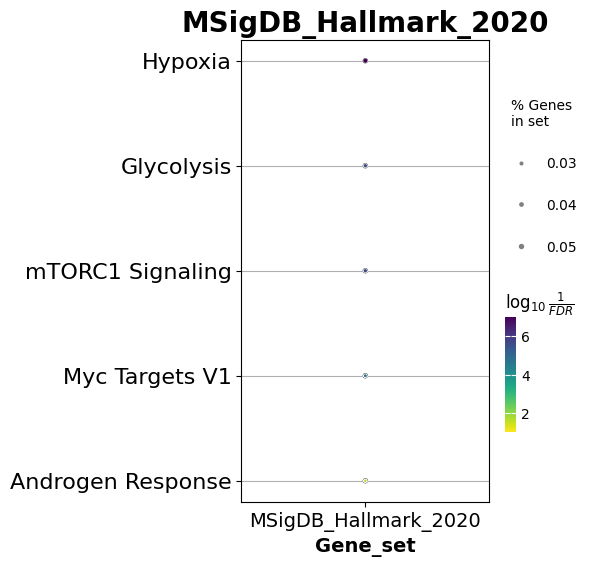

In [40]:
#Show top 5 terms of each gene_set ranked by “Adjusted P-value”
ax = dotplot(enr.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=10,
              top_term=5,
              figsize=(4,6),
              title = "MSigDB_Hallmark_2020", 
              show_ring=True, # set to False to revmove outer ring
              marker='o',
             )

 We immediately see that the gene sets that are over-represented are the ones corresponding to: Hypoxia. This is of course to be expected, since we have used as our gene list the genes that are relevant for classification of hypoxia.

It is moreover clear that in <code>enr.results</code>, the highest overlap is the one for Hypoxia, which means that the number of genes that overlap between our gene list and the genes in the specific gene set chosen is 10/200

